# Project: Bitcoin Time-Series Analysis

## Data:
1. Main Metrics: https://coinmetrics.io/community-network-data/
2. Crypto Fear & Greed Index Over Time: https://alternative.me/crypto/
3. Tweets Likes: https://www.kaggle.com/handsomeooi/sentiment-analysis/


## Features:

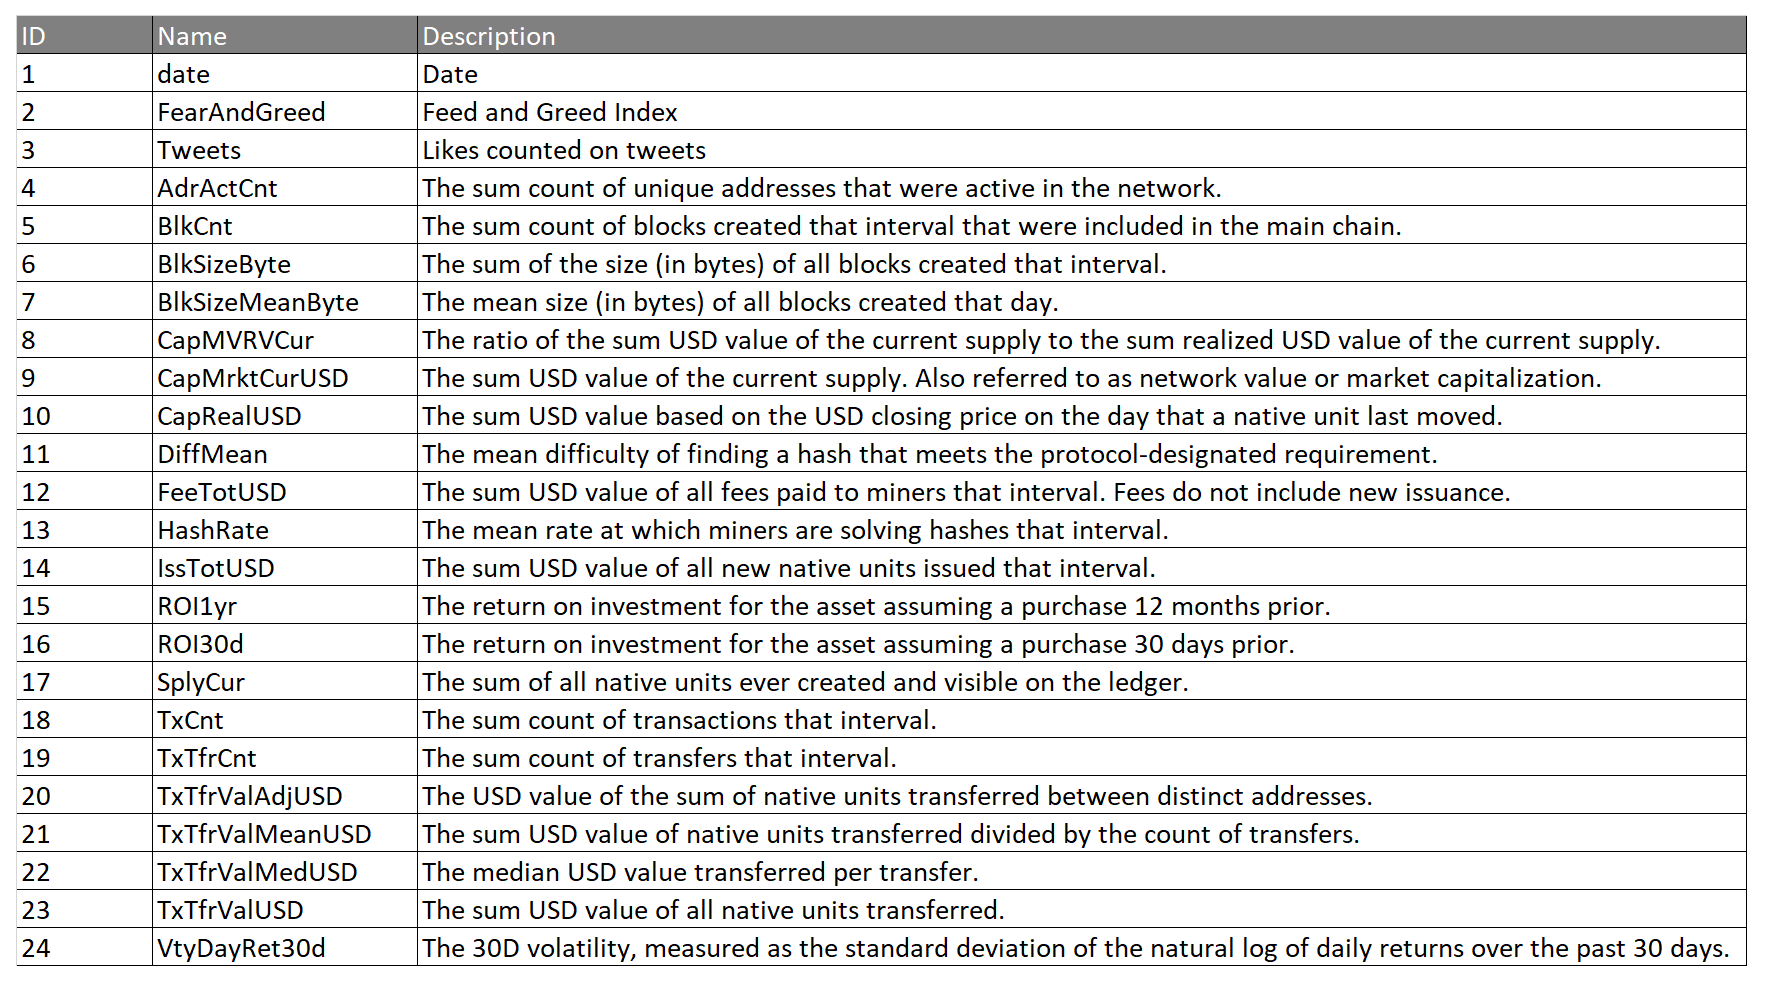

## Target:

Forecast daily Bitcoin PriceUSD for D+1 to D+7

    

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import stats


from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as ss

import warnings
warnings.filterwarnings('ignore')

# Data Preparation

1. Read data 
2. Check main statistic (description, type, null values etc.)
2. Change "date" to index

## Pipeline 0 

1. Cut Data - start from index where Price is not null
2. Change object type to Float --> for PriceUSD and TxTfrValMedUSD
3. Fill null values with data --> for PriceUSD and TxTfrValMedUSD
4. Remove columns were corr 0.6 < 0 < -0.6


## Pipeline 1

1. Use dataset from Pipeline 0 
2. Remove Fear&Greed and Tweet features


## Pipeline 2 - not implemented yet

1. Use dataset from Pipeline 0
2. For null Fear&Greed values use default values = 50 - this is neutral rating
3. For null Twee values use Median 


### Read Data

In [2]:
import pandas as pd
url = 'https://raw.githubusercontent.com/TomaszDudzik/BitcoinTimeSeriesForecasting/main/Data.xlsx'
raw_df = pd.read_excel(url)

In [ ]:
# show first rows
raw_df.head()

In [ ]:
# show size of the dataset
raw_df.shape

In [ ]:
# show basic info about the dataset like type and null values
raw_df.info()

In [ ]:
# show null values
raw_df.isna().sum()

### Issues
1. Why PriceUSD is an Object Type?
2. Why TxtfrValMedUSD is an Object Type?
3. What to do with Null values for PriceUSD at the beggining of the dataset?
4. Are PriceUSD and PriceUSD1 duplicated columns?
5. What to do with Fear&Greed and Tweet columns?

### Change Object Type to Float

In [ ]:
# Check which rows are object type

raw_df.loc[raw_df[raw_df['PriceUSD'].apply(lambda x: isinstance(x, datetime.date))].index, 'PriceUSD']

In [ ]:
# Check which rows are object type

raw_df.loc[raw_df[raw_df['PriceUSD.1'].apply(lambda x: isinstance(x, datetime.date))].index, 'PriceUSD.1']

In [ ]:
# Check which rows are object type

raw_df.loc[raw_df[raw_df['TxTfrValMedUSD'].apply(lambda x: isinstance(x, datetime.date))].index, 'TxTfrValMedUSD']

In [3]:
# Remove values from rows as object type and change the type to float

raw_df.loc[raw_df[raw_df['PriceUSD'].apply(lambda x: isinstance(x, datetime.date))].index, 'PriceUSD'] = None
raw_df['PriceUSD'] = raw_df.PriceUSD.astype(float)

raw_df.loc[raw_df[raw_df['PriceUSD.1'].apply(lambda x: isinstance(x, datetime.date))].index, 'PriceUSD.1'] = None
raw_df['PriceUSD.1'] = raw_df['PriceUSD.1'].astype(float)

raw_df.loc[raw_df[raw_df['TxTfrValMedUSD'].apply(lambda x: isinstance(x, datetime.date))].index, 'TxTfrValMedUSD'] = None
raw_df['TxTfrValMedUSD'] = raw_df.TxTfrValMedUSD.astype(float)

### Prepare and check if time series dataset

In [4]:
# change date column to index
raw_df = raw_df.set_index('date')
raw_df.index = pd.to_datetime(raw_df.index)

In [ ]:
# is data sorted
(raw_df.index == raw_df.index.sort_values()).all()

In [ ]:
# stable frequency
print(pd.infer_freq(raw_df.index))

### Duplicates

In [ ]:
raw_df.index.duplicated().sum()

### Trend and data values

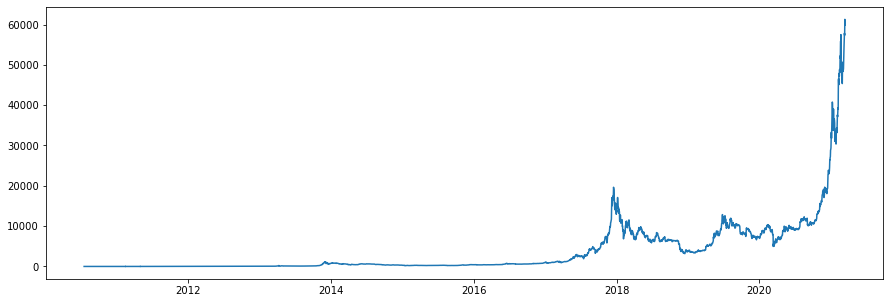

In [5]:
plt.figure(figsize=(15,5))
plt.plot(raw_df['PriceUSD']);

In [ ]:
# missing values at the beggining and some empty values somewhere in the middle

plt.figure(figsize=(15,5))
plt.plot(raw_df['PriceUSD'].loc[:'2012-01']);

-- logarytm
#raw_df['PriceUSD'] = np.log(raw_df['PriceUSD'])
#plt.figure(figsize=(12,6))
#plt.plot(ts_log)
#plt.show()

### Correlation

In [ ]:
plt.figure(figsize=(25,15))
sns.heatmap(raw_df.corr(), annot=True)

In [ ]:
plt.figure(figsize=(3,10))
sns.heatmap(pd.DataFrame(raw_df.corr()['PriceUSD']), annot=True)

In [ ]:
# PriceUSD and PriceUSD.1 are duplicated columns

plt.figure(figsize=(15,5))
plt.plot(raw_df['PriceUSD']/raw_df['PriceUSD.1']);

In [ ]:
# PriceUSD divided by CapMrktCurUSD 

plt.figure(figsize=(15,5))
plt.plot(raw_df['PriceUSD']/raw_df['CapMrktCurUSD']);

In [6]:
# Correlation - columns with < 0.5 corr

correlation = raw_df.corr()['PriceUSD']
not_correlated_columns = correlation[correlation < 0.5].index.tolist()
print(not_correlated_columns)

['BlkCnt', 'CapMVRVCur', 'ROI1yr', 'ROI30d', 'VtyDayRet30d']


## Pipeline 0

1. Cut Data - start from index where Price is not null
2. Fill null values with data --> for PriceUSD and TxTfrValMedUSD
3. Remove columns were corr < 0.5

In [7]:
# Transformer to reduce the datasize to start from rows where Price is populated

class CutDateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, start_date):
        self.start_date = start_date
    
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        return X.loc[self.start_date:]

In [8]:
# Transformer to fill empty values (none) with forward method for specified columns

class ImputeMissingValuesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, missing_values_columns: list):
        self.missing_values_columns = missing_values_columns
        
    def fit(self, X, y = None ):  
        return self 
    
    def transform( self, X, y = None ):
        X[missing_values_columns] = X[missing_values_columns].fillna(method='ffill')
        return X

In [9]:
# Transformer to remove not needed columns 

class RemoveColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_remove: list):
        self.columns_to_remove = columns_to_remove
    
    # even if nothing to fit, this method must return self
    def fit(self, X, y = None ):
        return self 
    
    def transform(self, X, y = None ):
        return X.drop(self.columns_to_remove, axis=1)

In [10]:
# Pipeline with steps

# Columns to remove 
# - PriceUSD.1 as duplication, 
# - not_correlated_columns
columns_to_remove = ['PriceUSD.1', 'BlkCnt', 'CapMVRVCur', 'ROI1yr', 'ROI30d', 'VtyDayRet30d']

# Columns with missing values which we will fill in with forward looking method (previous values) 
missing_values_columns = ['PriceUSD','TxTfrValMedUSD']

# Index where PriceUSD is not null by the first time in the dataset
start_date = raw_df['PriceUSD'].first_valid_index()

steps = [
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove = columns_to_remove)),
    ('fill_missing_values', ImputeMissingValuesTransformer(missing_values_columns = missing_values_columns)),
    ('cut_data', CutDateTransformer(start_date))
        ]

pipeline = Pipeline(steps=steps)
pipeline.fit(raw_df)
transformed0_df = pipeline.transform(raw_df)

### Check dataset after Pipeline 0

1. Fear&Greed and Tweets have null values.

In [11]:
transformed0_df.isna().sum()

PriceUSD              0
FearAndGreed       2758
Tweets              903
AdrActCnt             0
BlkSizeByte           0
BlkSizeMeanByte       0
CapMrktCurUSD         0
CapRealUSD            0
DiffMean              0
FeeTotUSD             0
HashRate              0
IssTotUSD             0
SplyCur               0
TxCnt                 0
TxTfrCnt              0
TxTfrValAdjUSD        0
TxTfrValMeanUSD       0
TxTfrValMedUSD        0
TxTfrValUSD           0
dtype: int64

In [ ]:
raw_df.shape

In [ ]:
transformed0_df.shape

### Two options:
    - Pipeline 1 - Remove Fear&Greed and Tweet features
    - Pipeline 2 - For null Fear&Greed values use default values = 50 and Tweets values use Median

## Piepeline 1
    - remove Fear&Greed and Tweets features

In [12]:
df_features = transformed0_df.copy()
df_features.head()

,PriceUSD,FearAndGreed,Tweets,AdrActCnt,BlkSizeByte,BlkSizeMeanByte,CapMrktCurUSD,CapRealUSD,DiffMean,FeeTotUSD,HashRate,IssTotUSD,SplyCur,TxCnt,TxTfrCnt,TxTfrValAdjUSD,TxTfrValMeanUSD,TxTfrValMedUSD,TxTfrValUSD
date,,,,,,,,,,,,,,,,,,,
2010-07-18,0.085840,NaN,NaN,860,136889,795.866279,295959.152000,2026.585401,181.543289,0.067814,0.001552,738.224000,3447800.0,248,396,1474.778412,4.187596,0.158804,1658.288022
2010-07-19,0.080800,NaN,35.0,929,139254,800.310345,279285.200000,4463.911468,181.543289,0.004040,0.001570,702.960000,3456500.0,334,512,3251.693384,7.025653,0.212100,3597.134392
2010-07-20,0.074736,NaN,60.0,936,197425,1090.745856,259000.404990,5741.958660,181.543289,0.000000,0.001633,676.358346,3465550.0,423,738,1200.497201,3.178423,0.102762,2345.676511
2010-07-21,0.079193,NaN,18.0,784,124991,603.821256,275266.471297,7176.328942,181.543289,0.000000,0.001868,819.646128,3475900.0,247,377,1649.915979,5.687816,1.465068,2144.306726
2010-07-22,0.058470,NaN,NaN,594,100750,572.443182,203749.573975,8107.064743,181.543289,0.000000,0.001588,514.533891,3484700.0,221,344,1932.368865,6.590397,0.059054,2267.096549


In [14]:
def generate_date_features(df_features):
    df_features['date'] = pd.to_datetime(df_features.index)
    df_features['month'] = df_features['date'].dt.month
    df_features['month_day'] = df_features['date'].dt.day
    df_features['day_of_week'] = df_features['date'].dt.dayofweek 
    df_features['is_weekend'] = np.where(df_features['day_of_week'].isin([5, 6]), 1, 0)
    return df_features

In [15]:
df_features = generate_date_features(df_features)
df_features

,PriceUSD,FearAndGreed,Tweets,AdrActCnt,BlkSizeByte,BlkSizeMeanByte,CapMrktCurUSD,CapRealUSD,DiffMean,FeeTotUSD,...,TxTfrCnt,TxTfrValAdjUSD,TxTfrValMeanUSD,TxTfrValMedUSD,TxTfrValUSD,date,month,month_day,day_of_week,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2010-07-18,0.085840,NaN,NaN,860,136889,7.958663e+02,2.959592e+05,2.026585e+03,1.815433e+02,6.781360e-02,...,396,1.474778e+03,4.187596,0.158804,1.658288e+03,2010-07-18,7,18,6,1
2010-07-19,0.080800,NaN,35.0,929,139254,8.003103e+02,2.792852e+05,4.463911e+03,1.815433e+02,4.040000e-03,...,512,3.251693e+03,7.025653,0.212100,3.597134e+03,2010-07-19,7,19,0,0
2010-07-20,0.074736,NaN,60.0,936,197425,1.090746e+03,2.590004e+05,5.741959e+03,1.815433e+02,0.000000e+00,...,738,1.200497e+03,3.178423,0.102762,2.345677e+03,2010-07-20,7,20,1,0
2010-07-21,0.079193,NaN,18.0,784,124991,6.038213e+02,2.752665e+05,7.176329e+03,1.815433e+02,0.000000e+00,...,377,1.649916e+03,5.687816,1.465068,2.144307e+03,2010-07-21,7,21,2,0
2010-07-22,0.058470,NaN,NaN,594,100750,5.724432e+02,2.037496e+05,8.107065e+03,1.815433e+02,0.000000e+00,...,344,1.932369e+03,6.590397,0.059054,2.267097e+03,2010-07-22,7,22,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-10,56116.040912,68.0,NaN,1165773,194008352,1.302069e+06,1.046580e+12,2.937410e+11,2.144828e+13,6.136344e+06,...,982213,1.181293e+10,27995.045791,197.632840,2.749710e+10,2021-03-10,3,10,2,0
2021-03-11,57847.254936,73.0,NaN,1084417,168874631,1.279353e+06,1.078915e+12,2.970769e+11,2.144828e+13,6.493051e+06,...,922585,1.359651e+10,34049.338230,204.123295,3.141341e+10,2021-03-11,3,11,3,0
2021-03-12,57334.641535,70.0,NaN,1186618,197235362,1.314902e+06,1.069408e+12,2.995049e+11,2.144828e+13,6.674894e+06,...,983349,1.328581e+10,30816.215737,170.283885,3.030309e+10,2021-03-12,3,12,4,0


(3400.0, 3900.0)

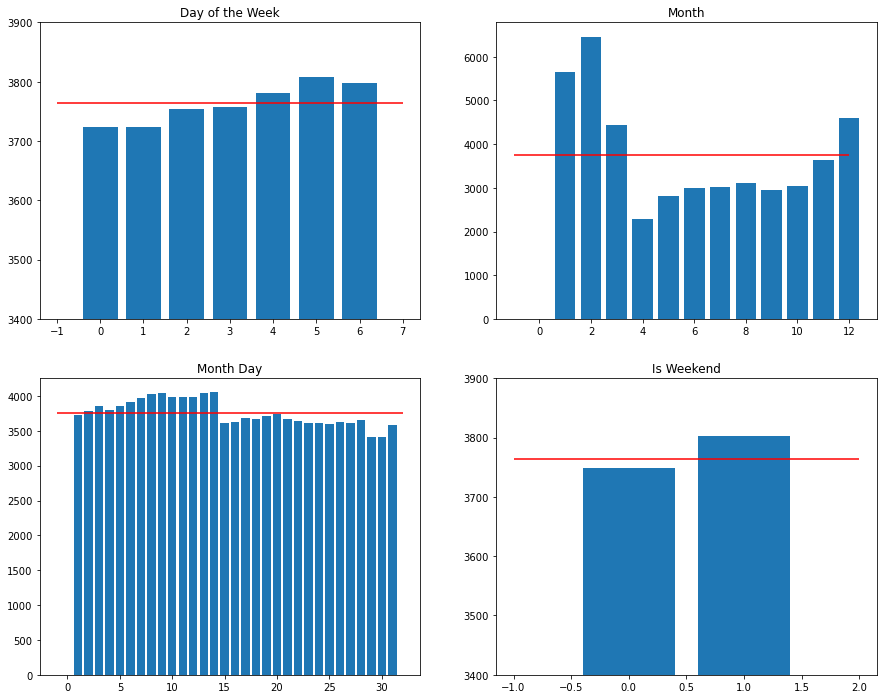

In [16]:
day_of_week = sorted(list(df_features['day_of_week'].unique()))
month = sorted(list(df_features['month'].unique()))
month_day = sorted(list(df_features['month_day'].unique()))
is_weekend = sorted(list(df_features['is_weekend'].unique()))

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Mean of PriceUSD depending on the day of week (0 - Monday; ... 6 - Sunday)
axs[0, 0].set_title('Day of the Week')
axs[0, 0].bar(day_of_week,df_features.groupby('day_of_week').mean()['PriceUSD'])
axs[0, 0].hlines(df_features['PriceUSD'].mean(), xmin=-1, xmax=7, color='red')
axs[0, 0].set_ylim(3400, 3900)

# Mean of PriceUSD depending on the month
axs[0, 1].set_title('Month')
axs[0, 1].bar(month,df_features.groupby('month').mean()['PriceUSD'])
axs[0, 1].hlines(df_features['PriceUSD'].mean(), xmin=-1, xmax=12, color='red')

# Mean of PriceUSD depending on the day of month
axs[1, 0].set_title('Month Day')
axs[1, 0].bar(month_day,df_features.groupby('month_day').mean()['PriceUSD'])
axs[1, 0].hlines(df_features['PriceUSD'].mean(), xmin=-1, xmax=32, color='red')

# Mean of PriceUSD depending if this is a weekend or workday
axs[1, 1].set_title('Is Weekend')
axs[1, 1].bar(is_weekend,df_features.groupby('is_weekend').mean()['PriceUSD'])
axs[1, 1].hlines(df_features['PriceUSD'].mean(), xmin=-1, xmax=2, color='red')
axs[1, 1].set_ylim(3400, 3900)

### Next Steps
    - Create the Transformer with additional features (except "day of month" feature)

In [17]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        df_features = X.copy()
        
        df_features['date'] = pd.to_datetime(df_features.index)
        df_features['month'] = df_features['date'].dt.month
        df_features['day_of_week'] = df_features['date'].dt.dayofweek 
        df_features['is_weekend'] = np.where(df_features['day_of_week'].isin([5, 6]), 1, 0)
        
        
        # drop unnecessary columns
        df_features = df_features.drop('date', axis=1)
    
        return df_features

In [18]:
# Pipeline with steps

columns_to_remove = ['FearAndGreed', 'Tweets']

steps = [
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove = columns_to_remove)),
    ('FeatureEngineeringTransformer', FeatureEngineeringTransformer())
        ]

pipeline = Pipeline(steps=steps)
pipeline.fit(transformed0_df)
transformed1_df = pipeline.transform(transformed0_df)

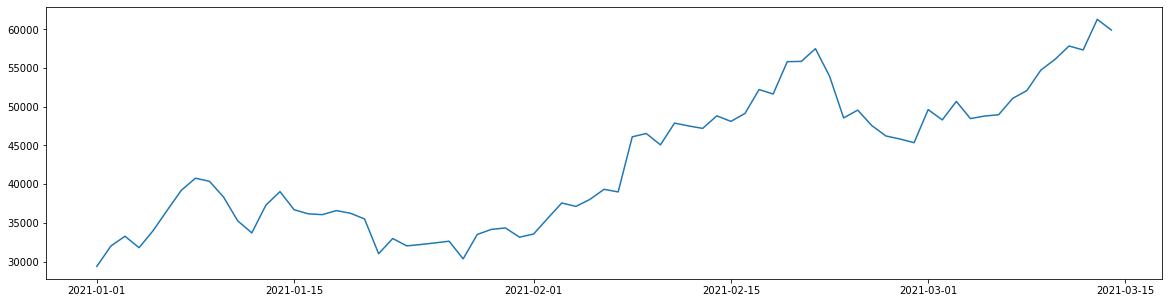

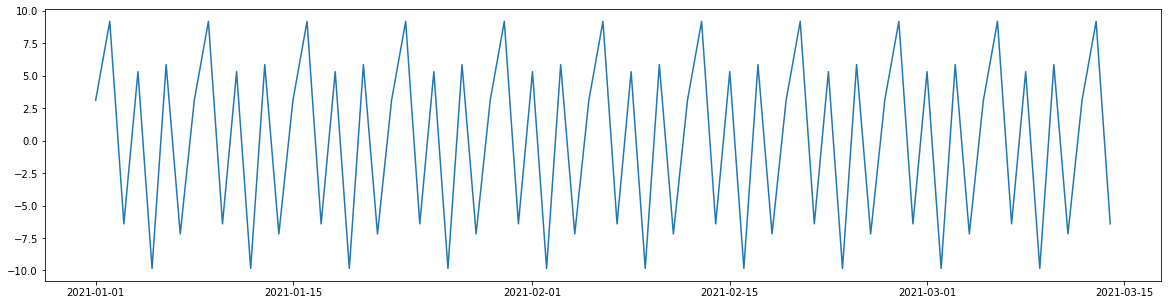

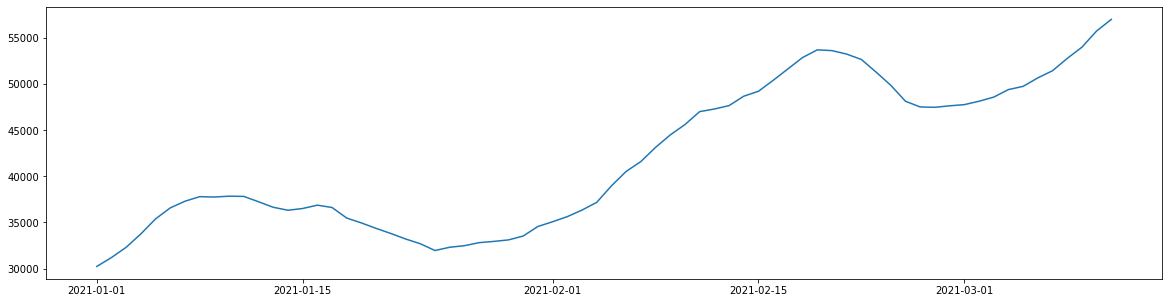

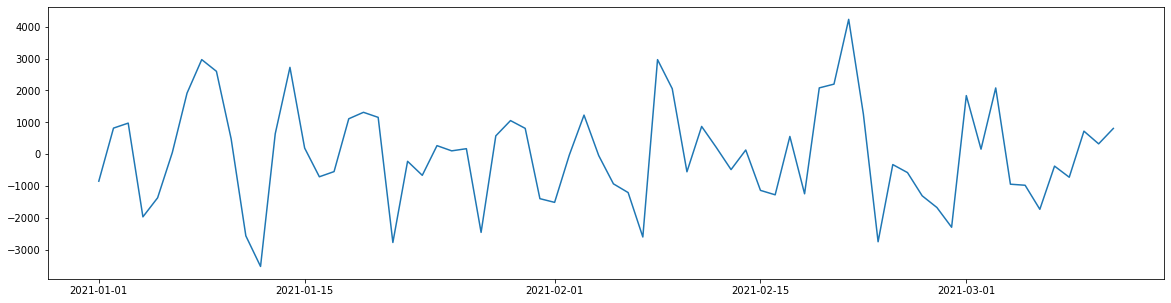

In [19]:
result = seasonal_decompose(transformed1_df['PriceUSD'])
transformed1_df['seasonality'] = result.seasonal
transformed1_df['trend'] = result.trend
plt.figure(figsize=(20,5))
plt.plot(transformed1_df['PriceUSD']['2021'])
plt.show()

plt.figure(figsize=(20,5))
plt.plot(transformed1_df['seasonality']['2021'])
plt.show()

plt.figure(figsize=(20,5))
plt.plot(transformed1_df['trend']['2021'])
plt.show()

plt.figure(figsize=(20,5))
plt.plot(result.resid['2021'])
plt.show()

In [20]:
trend = ImputeMissingValuesTransformer(['trend']).fit(transformed1_df)
df_final = trend.transform(transformed1_df)[3:]
df_final

,PriceUSD,AdrActCnt,BlkSizeByte,BlkSizeMeanByte,CapMrktCurUSD,CapRealUSD,DiffMean,FeeTotUSD,HashRate,IssTotUSD,...,TxTfrCnt,TxTfrValAdjUSD,TxTfrValMeanUSD,TxTfrValMedUSD,TxTfrValUSD,month,day_of_week,is_weekend,seasonality,trend
date,,,,,,,,,,,,,,,,,,,,,
2010-07-21,0.079193,784,124991,6.038213e+02,2.752665e+05,7.176329e+03,1.815433e+02,0.000000e+00,1.868085e-03,8.196461e+02,...,377,1.649916e+03,5.687816,1.465068,2.144307e+03,7,2,0,5.847943,0.070596
2010-07-22,0.058470,594,100750,5.724432e+02,2.037496e+05,8.107065e+03,1.815433e+02,0.000000e+00,1.588324e-03,5.145339e+02,...,344,1.932369e+03,6.590397,0.059054,2.267097e+03,7,3,0,-7.184637,0.065553
2010-07-23,0.060593,655,103001,5.309330e+02,2.117357e+05,9.130087e+03,1.815433e+02,6.059287e-04,1.750766e-03,5.877508e+02,...,335,1.166943e+03,3.826934,0.302964,1.282023e+03,7,4,0,3.106595,0.062010
2010-07-24,0.054540,959,287193,1.519540e+03,1.911000e+05,1.119382e+04,1.815433e+02,0.000000e+00,1.705643e-03,5.154030e+02,...,1112,2.149120e+03,2.130172,0.002727,2.368751e+03,7,5,1,9.178448,0.059708
2010-07-25,0.050541,2130,744810,3.224286e+03,1.776705e+05,1.242903e+04,1.815433e+02,1.470732e-01,2.084675e-03,5.837441e+02,...,3102,1.564202e+03,0.762873,0.021227,2.366431e+03,7,6,1,-6.408671,0.056811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-10,56116.040912,1165773,194008352,1.302069e+06,1.046580e+12,2.937410e+11,2.144828e+13,6.136344e+06,1.588638e+08,5.225806e+07,...,982213,1.181293e+10,27995.045791,197.632840,2.749710e+10,3,2,0,5.847943,55785.830011
2021-03-11,57847.254936,1084417,168874631,1.279353e+06,1.078915e+12,2.970769e+11,2.144828e+13,6.493051e+06,1.407384e+08,4.772399e+07,...,922585,1.359651e+10,34049.338230,204.123295,3.141341e+10,3,3,0,-7.184637,57045.708624
2021-03-12,57334.641535,1186618,197235362,1.314902e+06,1.069408e+12,2.995049e+11,2.144828e+13,6.674894e+06,1.599300e+08,5.375123e+07,...,983349,1.328581e+10,30816.215737,170.283885,3.030309e+10,3,4,0,3.106595,NaN


In [21]:
df_final.isna().sum()

PriceUSD           0
AdrActCnt          0
BlkSizeByte        0
BlkSizeMeanByte    0
CapMrktCurUSD      0
CapRealUSD         0
DiffMean           0
FeeTotUSD          0
HashRate           0
IssTotUSD          0
SplyCur            0
TxCnt              0
TxTfrCnt           0
TxTfrValAdjUSD     0
TxTfrValMeanUSD    0
TxTfrValMedUSD     0
TxTfrValUSD        0
month              0
day_of_week        0
is_weekend         0
seasonality        0
trend              3
dtype: int64

In [22]:
# Columns with missing values which we will fill in with forward looking method (previous values) 
missing_values_columns = ['trend']

# Index where PriceUSD is not null by the first time in the dataset
start_date = df_final['PriceUSD'].first_valid_index()

steps = [
    ('fill_missing_values', ImputeMissingValuesTransformer(missing_values_columns = missing_values_columns)),
        ]

pipeline = Pipeline(steps=steps)
pipeline.fit(df_final)
df_final = pipeline.transform(df_final)

In [23]:
df_final

,PriceUSD,AdrActCnt,BlkSizeByte,BlkSizeMeanByte,CapMrktCurUSD,CapRealUSD,DiffMean,FeeTotUSD,HashRate,IssTotUSD,...,TxTfrCnt,TxTfrValAdjUSD,TxTfrValMeanUSD,TxTfrValMedUSD,TxTfrValUSD,month,day_of_week,is_weekend,seasonality,trend
date,,,,,,,,,,,,,,,,,,,,,
2010-07-21,0.079193,784,124991,6.038213e+02,2.752665e+05,7.176329e+03,1.815433e+02,0.000000e+00,1.868085e-03,8.196461e+02,...,377,1.649916e+03,5.687816,1.465068,2.144307e+03,7,2,0,5.847943,0.070596
2010-07-22,0.058470,594,100750,5.724432e+02,2.037496e+05,8.107065e+03,1.815433e+02,0.000000e+00,1.588324e-03,5.145339e+02,...,344,1.932369e+03,6.590397,0.059054,2.267097e+03,7,3,0,-7.184637,0.065553
2010-07-23,0.060593,655,103001,5.309330e+02,2.117357e+05,9.130087e+03,1.815433e+02,6.059287e-04,1.750766e-03,5.877508e+02,...,335,1.166943e+03,3.826934,0.302964,1.282023e+03,7,4,0,3.106595,0.062010
2010-07-24,0.054540,959,287193,1.519540e+03,1.911000e+05,1.119382e+04,1.815433e+02,0.000000e+00,1.705643e-03,5.154030e+02,...,1112,2.149120e+03,2.130172,0.002727,2.368751e+03,7,5,1,9.178448,0.059708
2010-07-25,0.050541,2130,744810,3.224286e+03,1.776705e+05,1.242903e+04,1.815433e+02,1.470732e-01,2.084675e-03,5.837441e+02,...,3102,1.564202e+03,0.762873,0.021227,2.366431e+03,7,6,1,-6.408671,0.056811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-10,56116.040912,1165773,194008352,1.302069e+06,1.046580e+12,2.937410e+11,2.144828e+13,6.136344e+06,1.588638e+08,5.225806e+07,...,982213,1.181293e+10,27995.045791,197.632840,2.749710e+10,3,2,0,5.847943,55785.830011
2021-03-11,57847.254936,1084417,168874631,1.279353e+06,1.078915e+12,2.970769e+11,2.144828e+13,6.493051e+06,1.407384e+08,4.772399e+07,...,922585,1.359651e+10,34049.338230,204.123295,3.141341e+10,3,3,0,-7.184637,57045.708624
2021-03-12,57334.641535,1186618,197235362,1.314902e+06,1.069408e+12,2.995049e+11,2.144828e+13,6.674894e+06,1.599300e+08,5.375123e+07,...,983349,1.328581e+10,30816.215737,170.283885,3.030309e+10,3,4,0,3.106595,57045.708624


# Models Training

In [24]:
X = df_final.drop('PriceUSD', axis=1)
y = df_final['PriceUSD']

In [25]:
def mse(y_pred, y_true):
    return round(np.sqrt(mean_squared_error(y_pred, y_true)))

def get_roc_auc(model, X, y):
    y_score = model.predict_proba(X)[:, 1] # take the probability of the label 1
    return roc_auc_score(y_true=y.values, y_score=y_score)  

def get_accuracy(model, X, y):
    y_pred = model.predict(X)
    return accuracy_score(y_true=y, y_pred=y_pred)

def get_performance(model, X, y):
    return f"Accuracy: {get_accuracy(model, X, y): .2f}, AUC: {get_roc_auc(model, X, y): .3f} "

def naive_forecast(ts, period):
    actual = ts[period:]
    preds = ts.shift(period)[period:]
    
    return mse(actual, preds)

In [26]:
split_index = int(y.shape[0] * 0.8)
y_train, y_test = y[:split_index], y[split_index:]

In [27]:
for i in range(1,8):
    print(f'{i}: {naive_forecast(y_test, period=i)}')

1: 748
2: 1058
3: 1330
4: 1573
5: 1778
6: 1980
7: 2174


In [28]:
# przygotowujemy dane, te feature X muszimy przesunac = period powinien byc jeden - czyli predyckaj na jutro
def prepare_data(X, y, period, split_ratio):
    # define index border between train and test
    split_index = int(split_ratio*X.shape[0])
    
    # shift the features; remove missing values by slicing; target should be aligned with features
    X_shift = X.shift(period)[period:]
    y_shift = y[period:]
    
    # split original features and target on index
    X_train, X_test = X_shift[:split_index], X_shift[split_index:]
    y_train, y_test = y_shift[:split_index], y_shift[split_index:]
    
    return X_train, y_train, X_test, y_test

In [30]:
steps = [
    ('transform', PowerTransformer()), 
#    ('scale', MinMaxScaler()), 
    ('scale', StandardScaler()), 
#    ('pca', PCA()),
    ('Ada', AdaBoostRegressor())
#   ('SVR', SVR())
]
pipeline = Pipeline(steps=steps)

ada_preds = []
for period in range(1,2):
    X_train, y_train, X_test, y_test = prepare_data(X, y, period=period, split_ratio=0.75)

#    params = {'SVR__kernel': ['linear','poly', 'rbf', 'sigmoid', 'precomputed'],
#              'SVR__gamma': ['scale', 'auto']
#              }

    params = {'Ada__loss': ['square', 'exponential'],
              'Ada__n_estimators': [50],
              'Ada__learning_rate': [0.01]}


    cv = TimeSeriesSplit(n_splits=5).split(X_train)
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=cv, verbose=0)
    grid_search.fit(X_train, y_train)
    
    ada_model = grid_search.best_estimator_
    score = mse(ada_model.predict(X_test), y_test)
    pred = ada_model.predict(X.tail(1))[0]
    ada_preds.append(pred)
    print(f'Period: {period}')
    print(f'Forecast: {round(pred)} +/- {score}')
    print(ada_model)

Period: 1
Forecast: 16688 +/- 7729
Pipeline(steps=[('transform', PowerTransformer()), ('scale', StandardScaler()),
                ('Ada',
                 AdaBoostRegressor(learning_rate=0.01, loss='exponential'))])
